In [1]:
from factor_estimator import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from asset_allocation import AssetAllocation

%matplotlib inline

Factor investing is one of the most interesting approaches to "outperform the market" if the market is a usual market cap weighted portfolio (like MSCI World, MSCI ACWI, FTSE All World or to a degree a S&P500).
When diving into the literature one finds a whole host of factors which may be valuable. The most intersting ones come from Fama and French (Size (SmB), Value (HmL), Conservative (CvA) and Robustness (RmW). There are more out there like Momentum (Carhart, 1997) or Liquidity (Pástor, Stambaugh 2003).
Since the author of this analysis is based out of Germany, the amount of different investment options is limited. Thus we keep with the following selection, where the number represents the MSCI Index code:

In [2]:
index_codes = get_common_index_codes()
index_codes.pop("Small-Cap")
print(index_codes)


{'MSCI World': {'code': '990100', 'region': 'Developed'}, 'Value': {'code': '705130', 'region': 'Developed'}, 'Quality': {'code': '702787', 'region': 'Developed'}, 'Multi-Factor': {'code': '706536', 'region': 'Developed'}, 'Momentum': {'code': '703755', 'region': 'Developed'}, 'Low Volatility (World)': {'code': '129896', 'region': 'Developed'}, 'Small-Cap (Value)': {'code': '139249', 'region': 'US'}, 'High-Dividend (World)': {'code': '136064', 'region': 'Developed'}}


The question asked in this analysis is: **How do I mix the ETFs for the indecies** above?

In general there are two approaches for factor investing. The integrated approach uses one etf where the stocks are picked to satisfy more then one factor at a time. Those ETFs are a one-stop solution, but have significantly higher costs. Also there is currently only a very limited selection available in Germany. The most important one is [iShares Edge MSCI World Multifactor](https://www.justetf.com/de-en/etf-profile.html?isin=IE00BZ0PKT83) which is based on the WORLD DIVERSIFIED MULTI-FACTOR index.
The TER for this is 0.5% and thus its ~0.35% higher than a market neutral MSCI World and ~0.2% higher than most 'single factor ETF' (exception is Value Weighted Small Caps).

The other approach is a *index of indicies* where you mix different ETFs to target more than a single factor. The reasoning behind that is, that factors are not stable over time and it is desireable to target more than one for continuity.

In this analysis we will try to estimate the 5 factors of the Fama French 5-Factor model. Those are MKT, SMB, HML, CWA and RMW. We then try to find the most suitable combination of ETFs for our purposes.

Let's get the data first. The data is directly taking from MSCI, and is thus available for a longer range. We examine data from 1998-2020, since this is the time span with daily data available. Every point is always normalized to the 01/01/1997, so we can look at it like we invested a euro back then.

In [3]:
data = []
start_date="19981130"
for key in index_codes.keys():
    code = index_codes[key]["code"]
    d = get_prices(code,start_date=start_date)
    d.rename(columns={"level_eod":key}, inplace=True)
    d.set_index("date")
    data.append(d)
df = data[0]
for i in range(1,len(data)):
    df = df.merge(data[i], how='left')
    
#df = pd.concat(data).groupby(level=0).first()
df.set_index("date")

,MSCI World,Value,Quality,Multi-Factor,Momentum,Low Volatility (World),Small-Cap (Value),High-Dividend (World)
date,,,,,,,,
1998-11-30,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1998-12-31,1.049005,1.024456,1.067599,1.066349,1.095955,1.048357,1.040312,1.026448
1999-01-29,1.072120,1.039514,1.107618,1.084851,1.147905,1.036790,1.042894,1.027995
1999-02-26,1.043749,0.999014,1.067348,1.054852,1.105298,1.003339,0.956846,1.011383
1999-03-31,1.087360,1.067893,1.103971,1.118971,1.140390,1.021943,0.957336,1.031909
...,...,...,...,...,...,...,...,...
2020-12-28,4.074808,6.334964,6.048500,8.025629,7.758597,4.952238,10.255418,4.079426
2020-12-29,4.083397,6.376713,6.067578,8.029251,7.761189,4.968324,10.128684,4.101662
2020-12-30,4.089892,6.382743,6.070606,8.059754,7.776302,4.971178,10.248509,4.109089


To check the data and to understand, let's chart the data:

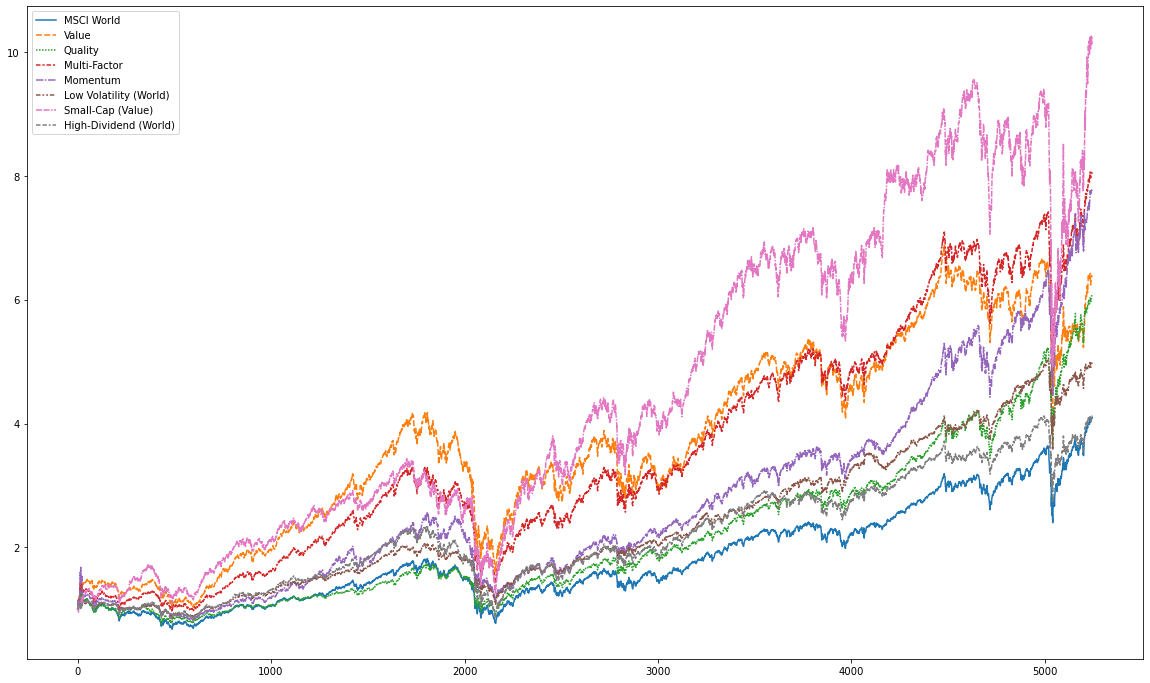

In [4]:
plt.figure(figsize=(20, 12))
gfg = sns.lineplot(data = df)

We can see that all factors outperform the MSCI World.
We can also see that the two best running factors are Momentum and Small-Cap (Value).

Lets now calculate the factors for each of our indicies. The idea is, that the change of market price w.r.t to the risk free return can be descriped as 
\begin{equation}
    r_f = a \cdot MKT+b \cdot SMB +c \cdot HML+d \cdot RMW+e \cdot CMA
\end{equation}
The original Fama French paper knew a,b,c,d and e for a given portfolio (those are metrics like P/E), and deterimed the influence factors.
We do it the other way around. We know the influence factors from the paper and want to determine the 'sizeness' of an index (so we determine a,b,c,d,e).

In [5]:
factors = {}
fit_results = {}
for key in index_codes.keys():
    code = index_codes[key]["code"]
    print("calculating for ",code)
    fitted_factors, results, data = estimate(code,start_date=start_date,region=index_codes[key]["region"])
    factors[key] = fitted_factors
    fit_results[key] = results

calculating for  990100
calculating for  705130
calculating for  702787
calculating for  706536
calculating for  703755
calculating for  129896
calculating for  139249
calculating for  136064


Before we move forward, lets have a look at the quality of the fit:

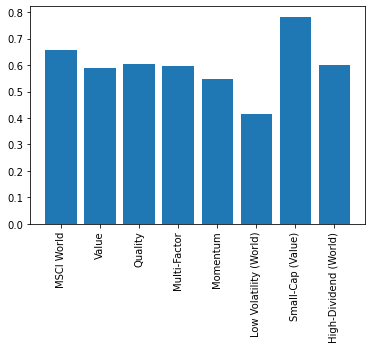

In [6]:
D={}
for key in factors.keys():
    D[key] = fit_results[key].rsquared
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)
plt.show()


From my perspective the r-squared value is relativily low.. The values of 0.4 are rather weak and maybe we should run further analysis here?
The original paper also quotes relativly low r² values. Maybe that's just normal?

We can also have a quick look at the global factorness of each index. Factorness is defined as
\begin{equation}
\phi = \sum_i f_i
\end{equation}
where $f_i$ is the individual factor. The key question of this analysis is if $\phi$ is the factor to optimize on or how to weight the individual contributions.

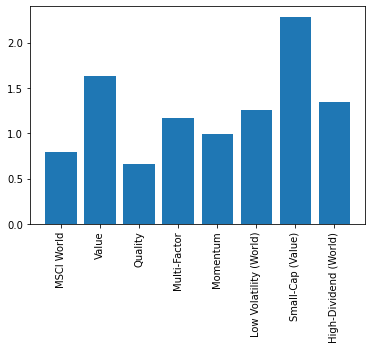

In [7]:
D={}
for key in factors.keys():
    D[key] = factors[key].sum()
plt.bar(*zip(*D.items()))
plt.xticks(rotation = 90)
plt.show()

What we can see here is kind of telling. The Multi-Factor index is not outstanding! If the Mult-Factor index is clearly surperior we would have expected a high value here.
Let's look into the details and the individual factor for each of the 5 factors of the model:

<ipython-input-8-b9eb012f6ba2>:17: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


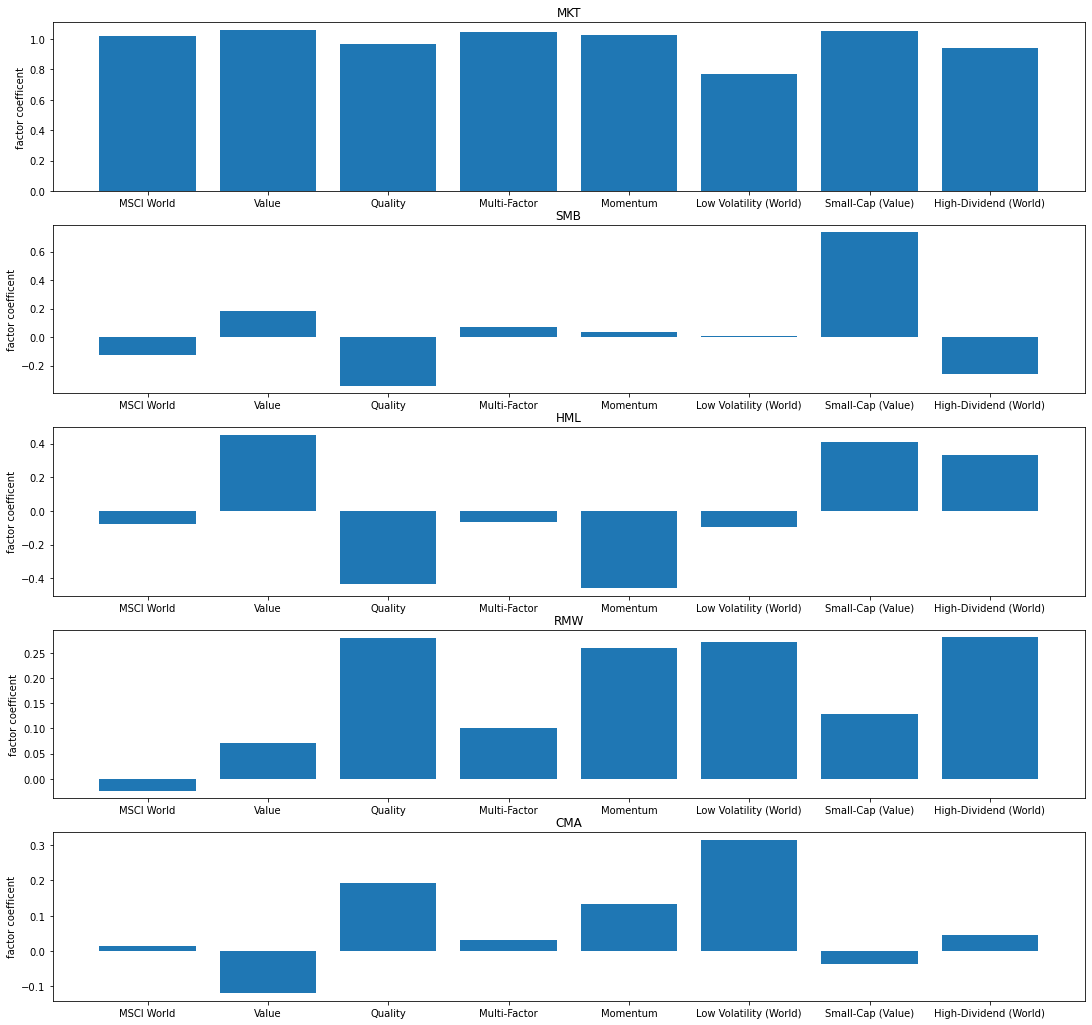

In [8]:
fig, axs = plt.subplots(5)
i = 0

for factorname in ["MKT","SMB","HML","RMW","CMA"]:
    D = {}
    for key in factors.keys():
        D[key] = factors[key][factorname]
    axs[i].bar(*zip(*D.items()))
    axs[i].set_title(factorname)
    #axs[i].set_ylim(-0.2,0.5)
    axs[i].set_ylabel("factor coefficent")
    i+=1
    


fig.set_size_inches(18.5, 18)
fig.show()

And for completness, lets look at it the other way around and see it grouped by the index:

<ipython-input-9-b7a9d13182b1>:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
<ipython-input-9-b7a9d13182b1>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


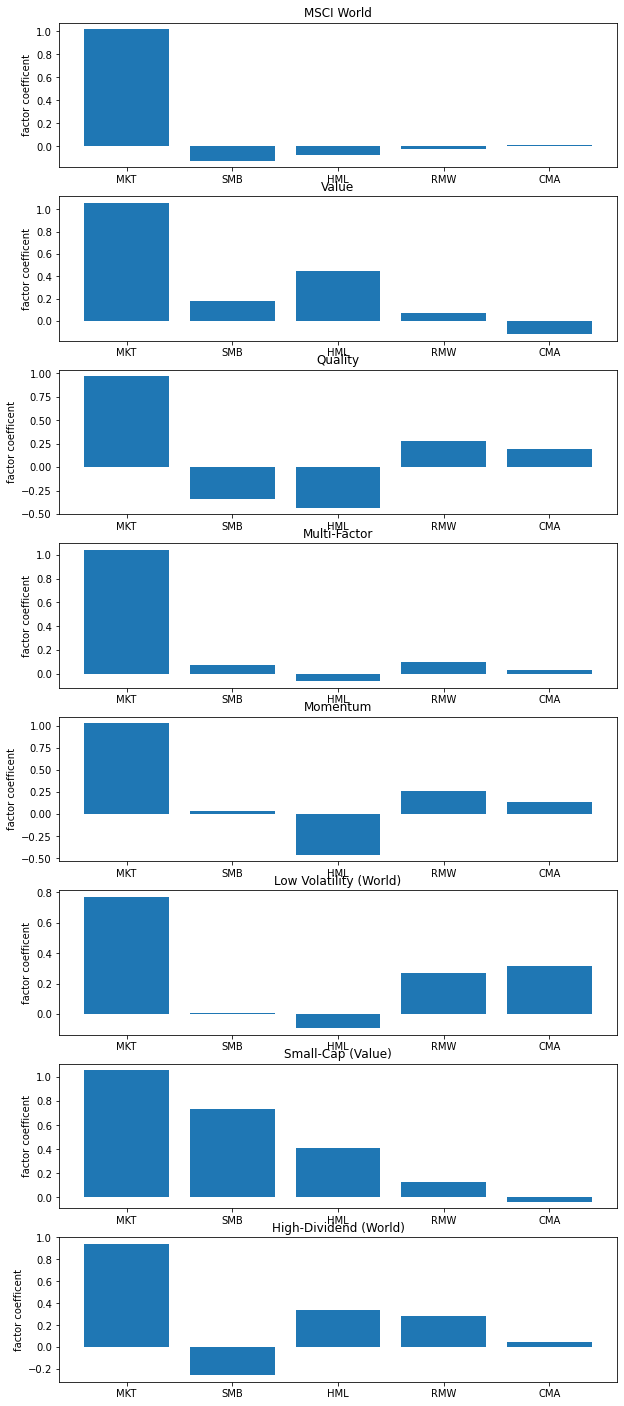

In [9]:
fig, ax = plt.subplots(len(index_codes))

width = 0.35  # the width of the bars
i = 0
for key in factors.keys():
    D = {}
    for factorname in ["MKT","SMB","HML","RMW","CMA"]:
        D[factorname] = factors[key][factorname]
        
    ax[i].bar(*zip(*D.items()),label=key)
    ax[i].set_title(key)
    #ax[i].set_ylim(-0.2,0.5)
    ax[i].set_ylabel("factor coefficent")
    i+=1
    


fig.tight_layout()
fig.set_size_inches(10, 25)
fig.show()

What can we learn from here? First: Small Cap (Value) seams to be a beast! It offers exposure to the market, SMB and HML! And it does not even have negative contributions to RMW and CMA. Wow! One needs to remind oneselve, that Small Cap (Value) only has a [single ETF](https://www.justetf.com/de-en/etf-profile.html?groupField=index&from=search&isin=IE00BSPLC413) in Germany which is relativly expensive (0.3% TER)

Lets move into the optimization. We first define our factor matrix

In [10]:
factor_matrix = pd.DataFrame.from_dict(factors).drop(["Intercept"],axis=0)

The factorness vector $\vec{f}$ can now be expressed as:
\begin{equation}
\vec{f} = \underline{F} \cdot \alpha
\end{equation}
Where $\underline{F}$ is the factor matrix and $\alpha$ our asset allocation vector.



In [11]:

index_names = df.columns.tolist()
index_names.remove("date")
numberOfIndecies = len(index_names)
def factorness(alpha):
  return factor_matrix.dot(alpha)
asset_allocations = {} # this will hold all proposals for later loops etc

For the reference, lets calculate the factorness vector and the total factorness for a pure multi-factor portfolio:

In [12]:
from asset_allocation import AssetAllocation

multi_factor_allocation = AssetAllocation(index_names)
multi_factor_allocation = multi_factor_allocation.set_allocation("Multi-Factor",1)
multi_factorness = factorness(multi_factor_allocation.to_array())
print("Factorness for pure multi-factor: ",multi_factorness)
print("Total Factorness: ", multi_factorness.sum())

world_allocation = AssetAllocation(index_names)
world_allocation = world_allocation.set_allocation("MSCI World",1)
world_factorness = factorness(world_allocation.to_array())
print("Factorness for pure world: ",world_factorness)
print("Total Factorness: ", world_factorness.sum())

asset_allocations["Pure Multi"] = multi_factor_allocation
asset_allocations["Pure World"] = world_allocation

Factorness for pure multi-factor:              0
MKT  1.043465
SMB  0.070747
HML -0.065442
RMW  0.101056
CMA  0.030803
Total Factorness:  0    1.180629
dtype: float64
Factorness for pure world:              0
MKT  1.017816
SMB -0.125962
HML -0.077697
RMW -0.023954
CMA  0.013704
Total Factorness:  0    0.803906
dtype: float64


We can now try to use a numerical optimization in order to find the result which maximizes the total factorness $\phi$. One key thing here is, that we need to specifiy bonds. If not the optimizer will throw everything into Small Cap (Value), since it's a beast.
Lets define bounds as \[0, 0.334\] and lets also deactivate the use of multi factor:

In [13]:

from scipy.optimize import minimize
# objective function
def func(alpha):
    return -1*factorness(alpha).sum()

# constraint: sum(weights) = 1
fconst = lambda w: 1 - sum(w)
cons   = ({'type':'eq','fun':fconst})

# initial weights
w0 =  np.ones((len(index_codes),1))/len(index_codes)

# define bounds
b    = (0.0, 0.334) 
bnds = [b for i in range(0,numberOfIndecies)]
bnds[3] = (0.0,0.0001)
# minimize
sol  = minimize(func,
                w0,
                bounds      = bnds,
                constraints = cons)

optimized_allocation = AssetAllocation(index_names)
optimized_allocation = optimized_allocation.set_allocations(sol.x)

print(-1*sol.fun)
print(optimized_allocation)
print(factorness(sol.x))
asset_allocations["Factor Optimized"] = optimized_allocation

1.7605728039315283
{'MSCI World': 1.3149524365969514e-15, 'Value': 0.33399999999999846, 'Quality': 2.466457125037749e-15, 'Multi-Factor': 5.1448186368928137e-17, 'Momentum': 9.291512206696497e-16, 'Low Volatility (World)': 0.0, 'Small-Cap (Value)': 0.33399999999999813, 'High-Dividend (World)': 0.3319999999999992}
MKT    1.018074
SMB    0.220572
HML    0.398708
RMW    0.159997
CMA   -0.036778
dtype: float64


The result is a portfolio which uses 33% Value, 33% Small-Cap Value and 33% Low Volatility.

**This factorness outpeforms the multi-factor etf!**

For reference, lets look at a few other portfolios. From the returns chart we may say, that we would like to use Small Cap (Value) and Momentum since they are well running. We may add either some Quality or Value to it to increase diversivication:

In [14]:
small_momentum_value_allocation = AssetAllocation(index_names);
small_momentum_value_allocation.set_allocation("Small-Cap (Value)",0.4)
small_momentum_value_allocation.set_allocation("Momentum",0.4)
small_momentum_value_allocation.set_allocation("Value",0.2)
small_momentum_value_factorness = factorness(small_momentum_value_allocation.to_array())
print(small_momentum_value_allocation)
print(small_momentum_value_factorness)
print(small_momentum_value_factorness.sum())
asset_allocations["Small-Momentum-Value"] = small_momentum_value_allocation

{'Small-Cap (Value)': 0.4, 'Momentum': 0.4, 'Value': 0.2}
            0
MKT  1.043450
SMB  0.345182
HML  0.070525
RMW  0.169957
CMA  0.014648
0    1.643762
dtype: float64


In [15]:

small_momentum_quality_allocation = AssetAllocation(index_names);
small_momentum_quality_allocation.set_allocation("Small-Cap (Value)",0.4)
small_momentum_quality_allocation.set_allocation("Momentum",0.4)
small_momentum_quality_allocation.set_allocation("Quality",0.2)
small_momentum_quality_factorness = factorness(small_momentum_quality_allocation.to_array())
print(small_momentum_quality_allocation)
print(small_momentum_quality_factorness)
print(small_momentum_quality_factorness.sum())
asset_allocations["Small-Momentum-Quality"] = small_momentum_quality_allocation

{'Small-Cap (Value)': 0.4, 'Momentum': 0.4, 'Quality': 0.2}
            0
MKT  1.025454
SMB  0.240402
HML -0.106549
RMW  0.211976
CMA  0.076815
0    1.448098
dtype: float64


As a last portfolio, lets look at an evenly distributed portfolio between value, quality, low Vola and Small Cap (Value):

In [16]:
even_allocations = AssetAllocation(index_names)
even_allocations.distribute_evenly()
even_factors = factorness(even_allocations.to_array())
print(even_allocations)
print(even_factors)
print(even_factors.sum())
asset_allocations["Even Allocation"] = even_allocations

{'MSCI World': 0.125, 'Value': 0.125, 'Quality': 0.125, 'Multi-Factor': 0.125, 'Momentum': 0.125, 'Low Volatility (World)': 0.125, 'Small-Cap (Value)': 0.125, 'High-Dividend (World)': 0.125}
            0
MKT  0.984652
SMB  0.038000
HML  0.008131
RMW  0.171464
CMA  0.071705
0    1.273953
dtype: float64


From those options especially the Value- Momentum -Small Cap Value one seems to be very interesting. It is slighly worse than the overall best one, but offers more expose to the MKT, which may be the one with the highest premium! The overall one therefore has a higher HML value

**This boils down to the key open question: How to weight the different factors?** 

As an idea, lets take the average factor values from FF, scale them to a year and take them as a weightening factor. We can then just calculate the returns as:
\begin{equation}
    r = \vec{f} \cdot \vec{P}
\end{equation}
Where P holds the averages of the factors.

*Note: Maybe we want to take the monthly factor values here?*

*Note2: Just scaling it ignores the compound effect*

*Note3: The Small Cap Value is like a US ETF, so ideally one may want to use the higher US values here?*


In [21]:
from factor_estimator import *
average_factors = get_average_factors("Developed")*252
print(average_factors)
def excess_returns(alpha):
    factors = factorness(alpha)
    returns = average_factors.dot(factors)
    return returns*100

          MKT       SMB       HML       RMW       CMA
mean  0.05916  0.004055  0.020214  0.041539  0.019974


We can now take our different portfolios from above and compare them in their expected returns.

{'Pure Multi': 6.550843412429668, 'Pure World': 5.741138118502464, 'Factor Optimized': 7.509449098925805, 'Small-Momentum-Value': 7.19081125894421, 'Small-Momentum-Quality': 6.982644028956004, 'Even Allocation': 6.712510600824604}


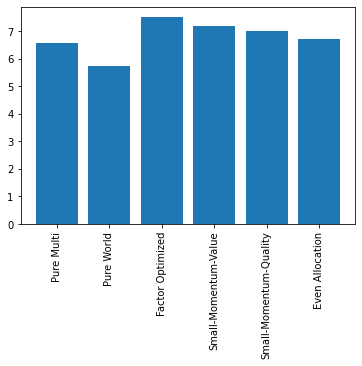

In [20]:
return_dict = {}
for key, value in asset_allocations.items():
    return_dict[key] = float(excess_returns(value.to_array()).iloc[0])
print(return_dict)
plt.bar(return_dict.keys(), return_dict.values())
plt.xticks(rotation = 90)
plt.show()

First important note, the expected returns of a multi-factor portfolio is ~1.3% higher than the normal one. This somewhat fits with some sources (like Kommer in his German book) quoting 1.5%.
Also it is interesting that the multi-factor once again 'does not shine' compared to the other ones. It seems like it is not worth it to invest into them.

The evenly distributed portfolio is again is not as good as the others, but you of course get diversification as a benefit

Like the last time, we can use numerical optimization to find the overall best one given our constraints of at least 3 indices:

In [19]:
from scipy.optimize import minimize
# objective function
def func(alpha):
    return -1*excess_returns(alpha)

# constraint: sum(weights) = 1
fconst = lambda w: 1 - sum(w)
cons   = ({'type':'eq','fun':fconst})

# initial weights
w0 =  np.ones((len(index_codes),1))/len(index_codes)

# define bounds
b    = (0.0, 0.333) 
bnds = [b for i in range(0,numberOfIndecies)]
bnds[3] = (0.0,0.0001)
# minimize
sol_returns  = minimize(func,
                w0,
                bounds      = bnds,
                constraints = cons)
print(sol_returns.fun)
for alloc, name in zip(sol_returns.x,factor_matrix.columns):
    print(name,"\n\t", alloc )
asset_allocations["Even Allocation"] = even_allocations

mean   -7.508231
dtype: float64
MSCI World 
	 0.0
Value 
	 0.333
Quality 
	 0.0
Multi-Factor 
	 9.999999999773054e-05
Momentum 
	 0.0008999999999875409
Low Volatility (World) 
	 0.0
Small-Cap (Value) 
	 0.333
High-Dividend (World) 
	 0.333


The result here is an even distribution between Momentum, Small-Cap (Value) and Value! It is a tiny bit better than the 0.4,0.4,0.2 distribution from above but offers more diversification. Sounds like we got a winner.

If you allow Mult-Factor into the mix, it is taken together with momentum, but the expected higher return is just 0.02% higher and thus not worth the costs.

It is somewhat funny to see, that the result of this longer analysis is a bit the trivial solution of taking the 3 best running ones and mixing them. The reason for this is that we do not yet consider volatility nor diversification as a constraint for our optimization.
